In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay, median_absolute_error
import numpy as np
from scipy.special import exp10
import plotly.express as px
import warnings

# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Formulating the task as a data problem, the goal is to develop a predictive model to determine the factors that significantly affect the prices of used cars. This requires the use of statistical techniques such as regression analysis to analyze the relationships between different car characteristics like manufacturer, mileage, condition and their effect on prices. By identifying the main drivers of car prices, we can create a predictive model that accurately estimates the value of used cars based on their characteristics, enabling better decisions on pricing strategies and market insights

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Data analysis steps:
1. Import data
2. Evaluate any null values
3. Evaluate numerical and non numerical columns

#### 1. Import Data

In [56]:
data = pd.read_csv('data/vehicles.csv')
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


#### 2. Evaluate any null values

In [57]:
print(data.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


#### 3. Evaluate numerical and non numerical columns

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70490 entries, 27 to 426878
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        70490 non-null  object 
 1   price         70490 non-null  int64  
 2   year          70490 non-null  float64
 3   manufacturer  70490 non-null  object 
 4   model         70490 non-null  object 
 5   condition     70490 non-null  int64  
 6   cylinders     70490 non-null  int64  
 7   fuel          70490 non-null  object 
 8   odometer      70490 non-null  float64
 9   title_status  70490 non-null  int64  
 10  transmission  70490 non-null  object 
 11  VIN           70490 non-null  object 
 12  drive         70490 non-null  object 
 13  size          70490 non-null  object 
 14  type          70490 non-null  object 
 15  paint_color   70490 non-null  object 
 16  state         70490 non-null  object 
dtypes: float64(2), int64(4), object(11)
memory usage: 9.7+ MB


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1. Remove ID column since it's not needed for our modeling.

In [59]:
data = data.drop(['id'], axis=1)

In [60]:
data.shape

(426880, 17)

2. Identify important columns that should not be NaN

In [61]:
data = data.dropna(subset=['manufacturer', 'type', 'VIN', 'condition', 'odometer', 'title_status', 'cylinders'])
data.shape

(83427, 17)

These columns are important and null values will affect our model so I've decided to remove the rows with null values for each of these columns.

3. We also don't need rows with prices less than 1000 and rows with vin equal to 0 as they are outliers

In [62]:
data = data[data['VIN']!='0']
data = data[data['price']>=1000]
data.shape

(78419, 17)

Convert cylinders column to int64

In [63]:
data['cylinders'] = data['cylinders'].str.replace(r'\D', '', regex=True)
data['cylinders'] = data['cylinders'].replace('', '0')
data['cylinders'] = data['cylinders'].astype('int64')

Map condition and title status to ordered numbers for visualizing

In [64]:
condition_mapping = {
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0,
}
title_status_mapping = {
    'clean': 5,
    'rebuilt': 4,
    'salvage': 3,
    'lien': 2,
    'missing': 1,
    'parts only': 0
}
data['condition'] = data['condition'].map(condition_mapping)
data['title_status'] = data['title_status'].map(title_status_mapping)

In [65]:
print(data.isnull().sum())

region              0
price               0
year                0
manufacturer        0
model             226
condition           0
cylinders           0
fuel                0
odometer            0
title_status        0
transmission        9
VIN                 0
drive           15001
size            44850
type                0
paint_color     10689
state               0
dtype: int64


In [66]:
data = data.fillna('other')

In [67]:
print(data.shape)
print(data.isnull().sum())

(78419, 17)
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


Remove duplicated rows as they are data errors

In [68]:
print("duplicate rows:",data.duplicated().sum())

duplicate rows: 7929


In [69]:
data = data.drop_duplicates()
print("duplicate rows:",data.duplicated().sum())
print(data.shape)

duplicate rows: 0
(70490, 17)


In [169]:
data.describe()

,price,year,condition,cylinders,odometer,title_status
count,70490.000000,70490.000000,70490.000000,70490.000000,7.049000e+04,70490.000000
mean,22432.799830,2012.918698,2.473259,6.121691,8.084958e+04,4.967244
std,13828.108439,6.703833,0.630889,1.515075,9.087377e+04,0.244544
min,1000.000000,1905.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,10295.000000,2011.000000,2.000000,6.000000,3.023700e+04,5.000000
50%,21700.000000,2014.000000,2.000000,6.000000,7.076000e+04,5.000000
75%,32590.000000,2017.000000,3.000000,8.000000,1.194500e+05,5.000000
max,349999.000000,2022.000000,5.000000,12.000000,9.999999e+06,5.000000


Text(0.5, 1.0, 'Fuel plot')

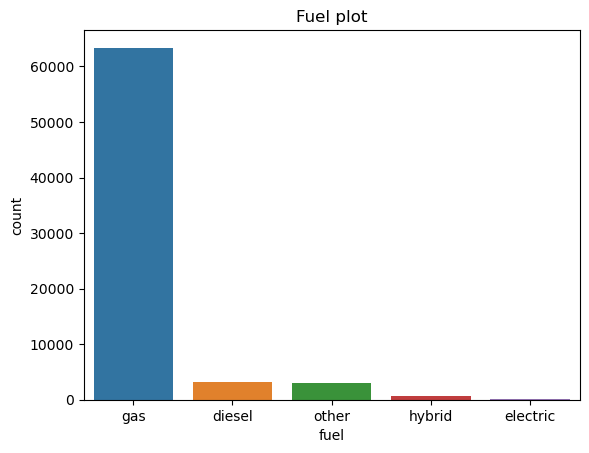

In [70]:
model_counts = data['fuel'].value_counts()  # Calculate the counts of each model
sorted_model_counts = model_counts.sort_values(ascending=False)
df_fuel = pd.DataFrame(sorted_model_counts)
sns.barplot(x=df_fuel.index, y='count', data=df_fuel)
plt.title("Fuel plot")

Text(0.5, 1.0, 'Transmission plot')

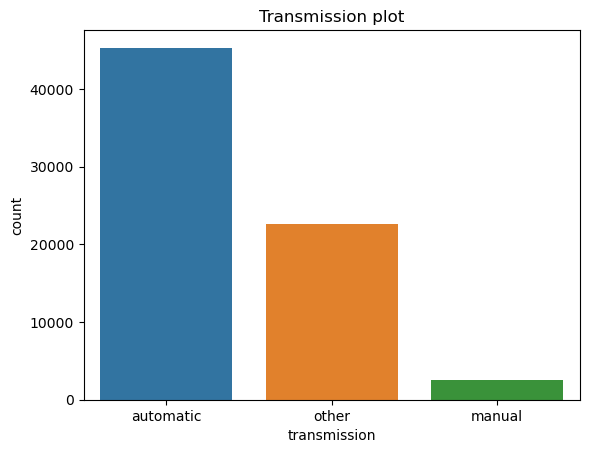

In [71]:
model_counts = data['transmission'].value_counts()  # Calculate the counts of each model
sorted_model_counts = model_counts.sort_values(ascending=False)
df_tran = pd.DataFrame(sorted_model_counts)
sns.barplot(x=df_tran.index, y='count', data=df_tran)
plt.title("Transmission plot")

Text(0.5, 1.0, 'condition plot')

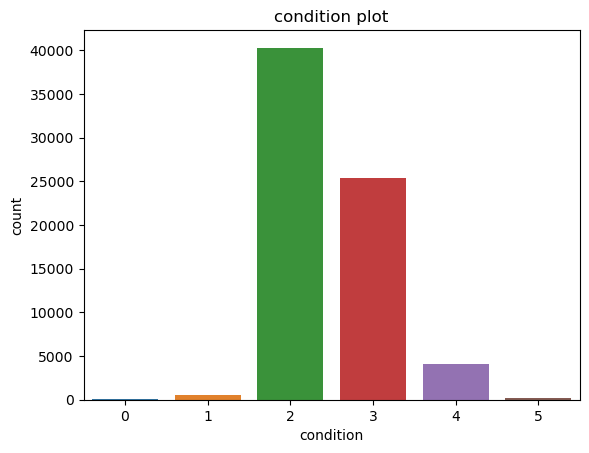

In [72]:
model_counts = data['condition'].value_counts()  # Calculate the counts of each model
sorted_model_counts = model_counts.sort_values(ascending=False)
df_cond = pd.DataFrame(sorted_model_counts)
sns.barplot(x=df_cond.index, y='count', data=df_cond)
plt.title("condition plot")

Text(0.5, 1.0, 'cylinders plot')

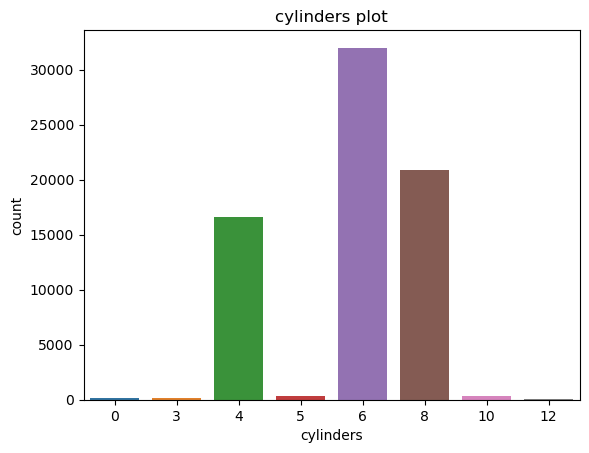

In [73]:
model_counts = data['cylinders'].value_counts()  # Calculate the counts of each model
sorted_model_counts = model_counts.sort_values(ascending=False)
df_cy = pd.DataFrame(sorted_model_counts)
sns.barplot(x=df_cy.index, y='count', data=df_cy)
plt.title("cylinders plot")

Text(0.5, 1.0, 'Title status vs Price correlation')

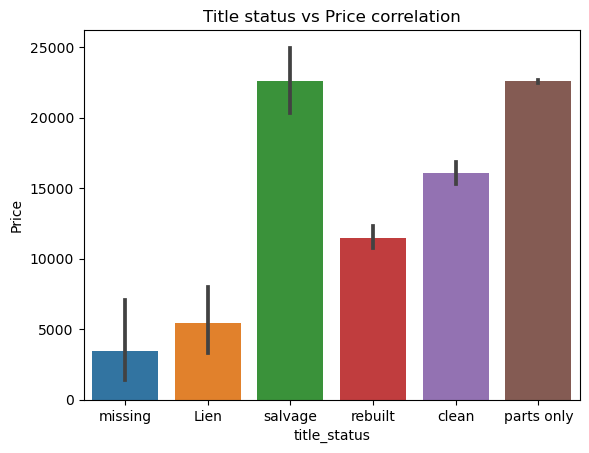

In [74]:
tick_positions = [0, 1, 2, 3, 4, 5]
tick_labels = ["missing", "Lien", "salvage", "rebuilt", "clean", "parts only"]
sns.barplot(x='title_status', y='price', data=data)
plt.xlabel('title_status')
plt.ylabel('Price')
plt.xticks(tick_positions, tick_labels)
plt.title('Title status vs Price correlation')

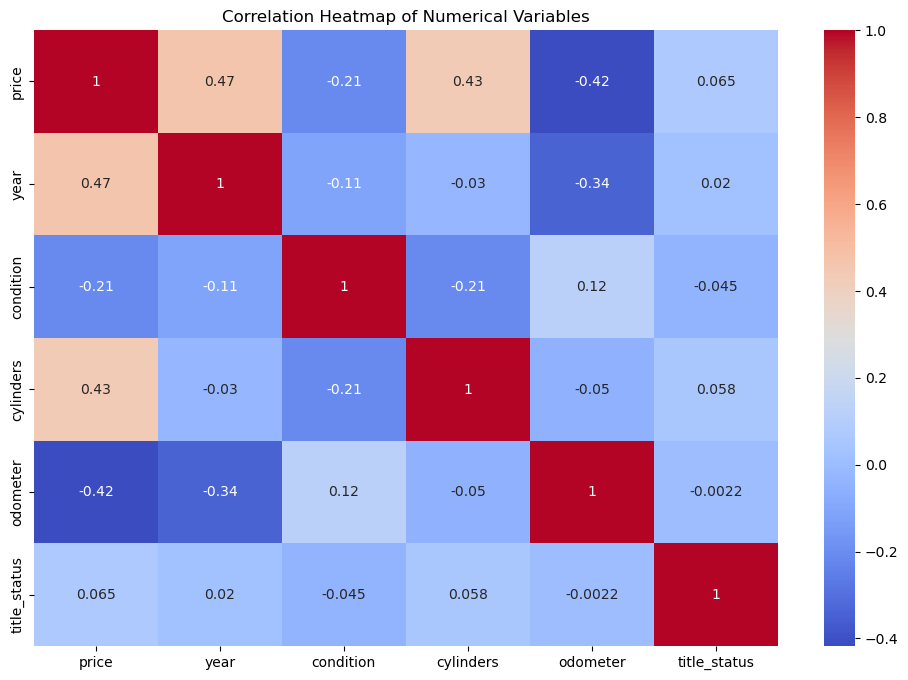

In [75]:
df1 = data.select_dtypes(include=['float64', 'int64'])
correlation = df1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.savefig('images/heatMap')

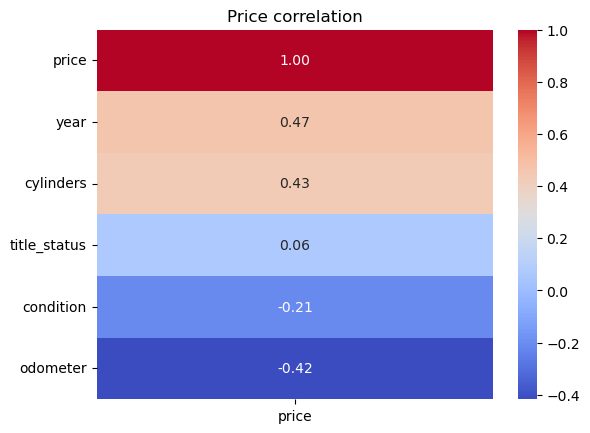

In [76]:
df1 = data.select_dtypes(include=['float64', 'int64'])
correlation = df1.corr()[['price']].sort_values(by='price', ascending=False)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Price correlation')
plt.savefig('images/priceCorr')

In [77]:
data.shape

(70490, 17)

Assign our X and y values to prepare for training our model

In [78]:
X = data.drop(['price', 'VIN'], axis=1)
y = data['price']

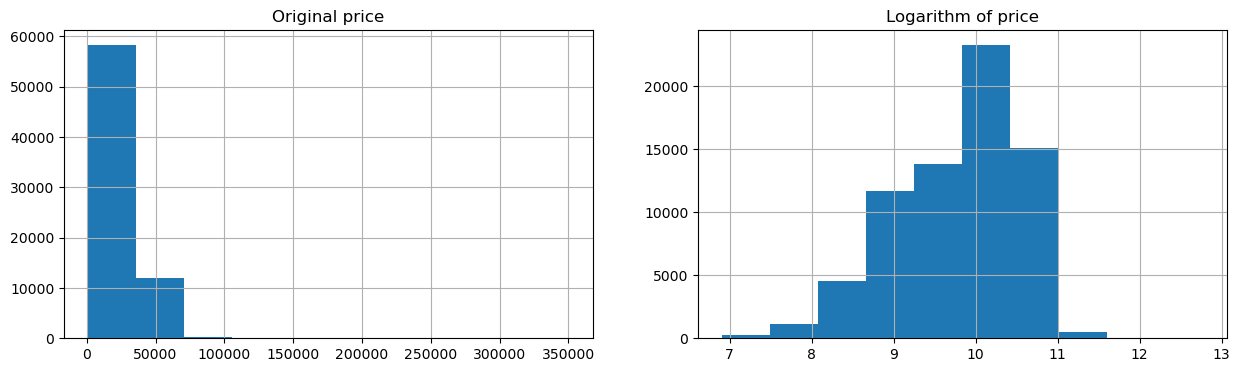

In [79]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].hist(y)
ax[0].grid()
ax[0].set_title('Original price')
ax[1].hist(np.log1p(y))
ax[1].grid()
ax[1].set_title('Logarithm of price');
plt.savefig('images/logPrice')

In [80]:
price_counts = y.value_counts()

# Extract price values and their frequencies
prices = price_counts.index
frequencies = price_counts.values

(0.0, 150000.0)

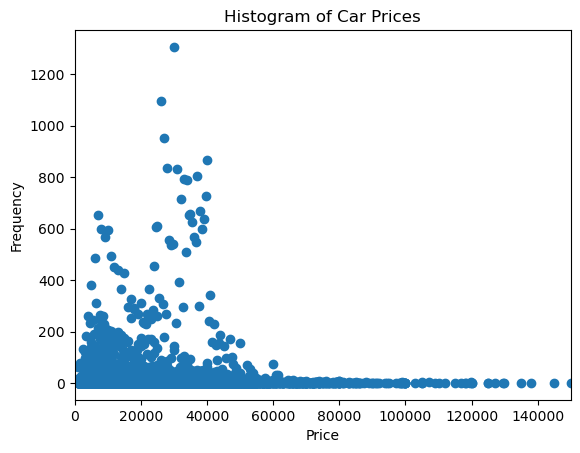

In [81]:
plt.scatter(prices, frequencies)
plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 150000)

Text(0.5, 1.0, 'Year vs Price correlation')

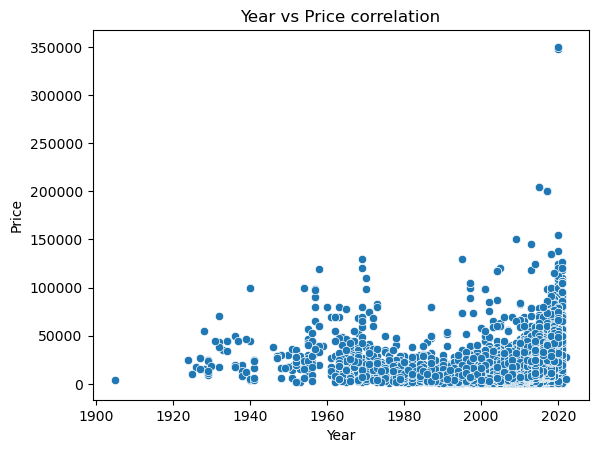

In [82]:
sns.scatterplot(x='year', y='price', data=data)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Year vs Price correlation')

Text(0.5, 1.0, 'cylinders vs Price correlation')

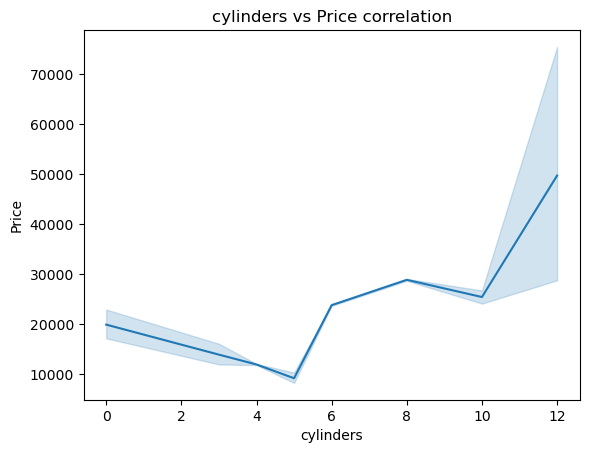

In [83]:
sns.lineplot(x='cylinders', y='price', data=data)
plt.xlabel('cylinders')
plt.ylabel('Price')
plt.title('cylinders vs Price correlation')

Normalize our y using log1p

In [84]:
y = np.log1p(y)

In [85]:
X['year'] = X['year'].astype('int64')
X['odometer'] = X['odometer'].astype('int64')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70490 entries, 27 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        70490 non-null  object
 1   year          70490 non-null  int64 
 2   manufacturer  70490 non-null  object
 3   model         70490 non-null  object
 4   condition     70490 non-null  int64 
 5   cylinders     70490 non-null  int64 
 6   fuel          70490 non-null  object
 7   odometer      70490 non-null  int64 
 8   title_status  70490 non-null  int64 
 9   transmission  70490 non-null  object
 10  drive         70490 non-null  object
 11  size          70490 non-null  object
 12  type          70490 non-null  object
 13  paint_color   70490 non-null  object
 14  state         70490 non-null  object
dtypes: int64(5), object(10)
memory usage: 8.6+ MB


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

##### Note: for each model, I'll be using MSE for error metric to penalize larger errors more heavily

Train test split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.3)

Build our transformer

In [87]:
categorical_columns = ['fuel', 
                    'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
numerical_columns = ['condition', 'cylinders', 'odometer', 'title_status', 'year']
transform = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

### 1. Linear Regression

In [141]:
linReg = Pipeline([('transform', transform),('regressor', LinearRegression(fit_intercept=False))])

In [142]:
linReg.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['condition', 'cylinders',
                                                   'odometer', 'title_status',
                                                   'year'])])),
                ('regressor', LinearRegression(fit_intercept=False))])

In [143]:
linPred_train = linReg.predict(X_train)
linPred_test = linReg.predict(X_test)
linMse_train = mean_squared_error(linPred_train,y_train)
linMse_test = mean_squared_error(linPred_test, y_test)
print('train MSE:',linMse_train)
print('test MSE: ',linMse_test)

train MSE: 0.1846858402449605
test MSE:  0.18086640148200211


In [144]:
r2_lin = r2_score(y_test, linPred_test)
train_r2 = r2_score(y_train, linPred_train)
print("R-squared train Score:", train_r2)
print("R-squared test Score:", r2)

R-squared train Score: 0.669430144027769
R-squared test Score: 0.8247529088163006


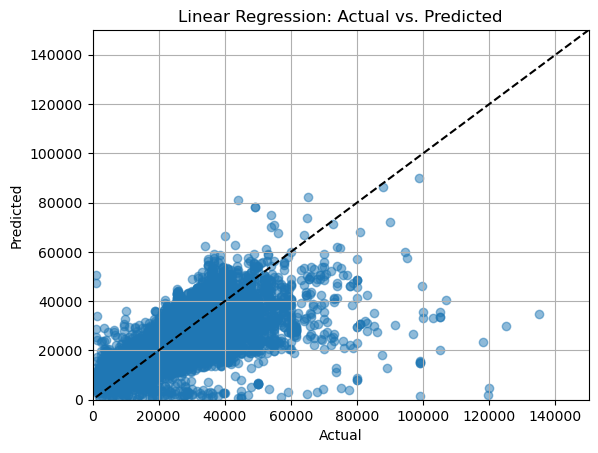

In [92]:
plt.scatter(np.expm1(y_test), np.expm1(linPred_test), alpha=0.5)
plt.plot([np.expm1(y.min()), np.expm1(y.max())], 
         [np.expm1(y.min()), np.expm1(y.max())],
         color='black', linestyle='--', label='Perfect Prediction')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.xlim(0, 150000)
plt.ylim(0, 150000)
plt.savefig('images/linearReg')

In [93]:
r = permutation_importance(linReg, X_test, y_test,n_repeats=30, random_state=42)
columns = []
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]:<8}"
            f"\t{r.importances_mean[i]:.3f}")
    columns.append(X_test.columns[i])
    columns.append(r.importances_mean[i])

year    	0.322
cylinders	0.079
transmission	0.074
odometer	0.066
type    	0.052
drive   	0.051
fuel    	0.036
size    	0.019
condition	0.015
state   	0.010
paint_color	0.003
title_status	0.001
model   	0.000
manufacturer	0.000
region  	0.000


### 2. Polynomial feature selection with Ridge regressor

In [107]:
ridgeReg = Pipeline([('transform', transform),
                     ('Poly', PolynomialFeatures(degree=2)),
                     ('regressor', Ridge())])

In [108]:
ridgeReg.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['condition', 'cylinders',
                                                   'odometer', 'title_status',
                                                   'year'])])),
                ('Poly', PolynomialFeatures()), ('regressor', Ridge())])

In [109]:
ridgePred_train = ridgeReg.predict(X_train)
ridgePred_test = ridgeReg.predict(X_test)
predMse_train = mean_squared_error(ridgePred_train, y_train)
predMse_test = mean_squared_error(ridgePred_test, y_test)
print('train MSE:',predMse_train)
print('test MSE: ',predMse_test)

train MSE: 0.0797815288425664
test MSE:  0.09580085603601914


In [145]:
r2_ridge = r2_score(y_test, ridgePred_test)
train_r2 = r2_score(y_train, ridgePred_train)
print("R-squared train Score:", train_r2)
print("R-squared test Score:", r2)

R-squared train Score: 0.8571987518710102
R-squared test Score: 0.8247529088163006


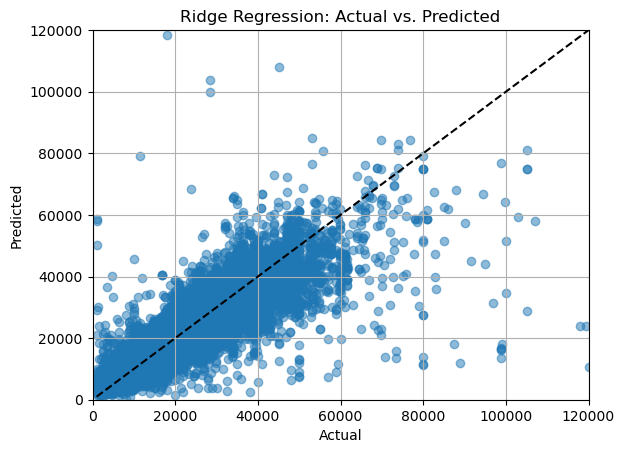

In [111]:
plt.scatter(np.expm1(y_test), np.expm1(ridgePred_test), alpha=0.5)
plt.plot([np.expm1(y.min()), np.expm1(y.max())],
         [np.expm1(y.min()), np.expm1(y.max())], 
         color='black', linestyle='--', label='Perfect Prediction')
plt.title('Ridge Regression: Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.xlim(0, 120000)
plt.ylim(0, 120000)
plt.savefig('images/ridgeReg')

In [99]:
r = permutation_importance(ridgeReg, X_test, y_test,n_repeats=30, random_state=42)
columns = []
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8}"
            f"\t{r.importances_mean[i]:.3f}")
    columns.append(X.columns[i])
    columns.append(r.importances_mean[i])

year    	0.397
odometer	0.163
type    	0.114
cylinders	0.103
drive   	0.073
transmission	0.072
size    	0.064
fuel    	0.040
state   	0.026
condition	0.024
paint_color	0.012
title_status	0.004
model   	0.000
manufacturer	0.000
region  	0.000


### 3. Ridge Regression with k-fold 5 cross validation

In [100]:
cvR = Pipeline([('transform', transform),('poly', PolynomialFeatures(degree=2)),('regressor', Ridge())])
param_grid = {
    'regressor__alpha': [1, 100, 1000]  # Example values for alpha
}
grid = GridSearchCV(estimator=cvR, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

In [101]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['condition',
                                                                          'cylinders',
                                                                          'odometer',
                                                                          'title_status',
                                                                          'year'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [1, 100, 1000]},
             scoring='neg_mean_squared_error')

In [102]:
best = grid.best_estimator_
best

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['fuel', 'transmission',
                                                   'drive', 'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['condition', 'cylinders',
                                                   'odometer', 'title_status',
                                                   'year'])])),
                ('poly', PolynomialFeatures()),
                ('regressor', Ridge(alpha=1000))])

In [103]:
best_train = best.predict(X_train)
best_test = best.predict(X_test)
bestMSE_Tn = mean_squared_error(best_train, y_train)
bestMSE_Tt = mean_squared_error(best_test, y_test)
print('train MSE:',bestMSE_Tn)
print('test MSE: ',bestMSE_Tt)

train MSE: 0.09141107020456392
test MSE:  0.09446264146415052


(0.0, 120000.0)

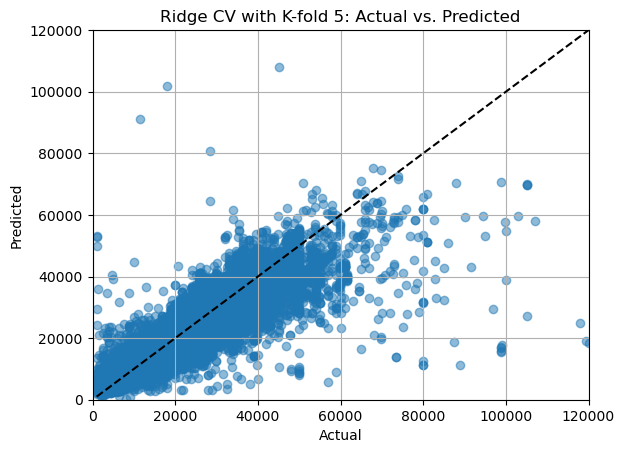

In [104]:
plt.scatter(np.expm1(y_test), np.expm1(best_test), alpha=0.5)
plt.plot([np.expm1(y.min()), np.expm1(y.max())],
         [np.expm1(y.min()), np.expm1(y.max())],
         color='black', linestyle='--', label='Perfect Prediction')
plt.title('Ridge CV with K-fold 5: Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.xlim(0, 120000)
plt.ylim(0, 120000)

In [146]:
r2_CV = r2_score(y_test, best_test)
train_r2 = r2_score(y_train, best_train)
print("R-squared train Score:", train_r2)
print("R-squared test Score:", r2)

R-squared train Score: 0.8363829935651239
R-squared test Score: 0.8247529088163006


In [170]:
r = permutation_importance(best, X_test, y_test,n_repeats=30, random_state=42)
columns = []
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8}"
            f"\t{r.importances_mean[i]:.3f}")
    columns.append(X.columns[i])
    columns.append(r.importances_mean[i])

year    	0.404
odometer	0.161
cylinders	0.108
type    	0.058
transmission	0.054
drive   	0.053
fuel    	0.031
condition	0.020
size    	0.019
state   	0.009
title_status	0.005
paint_color	0.004
model   	0.000
manufacturer	0.000
region  	0.000


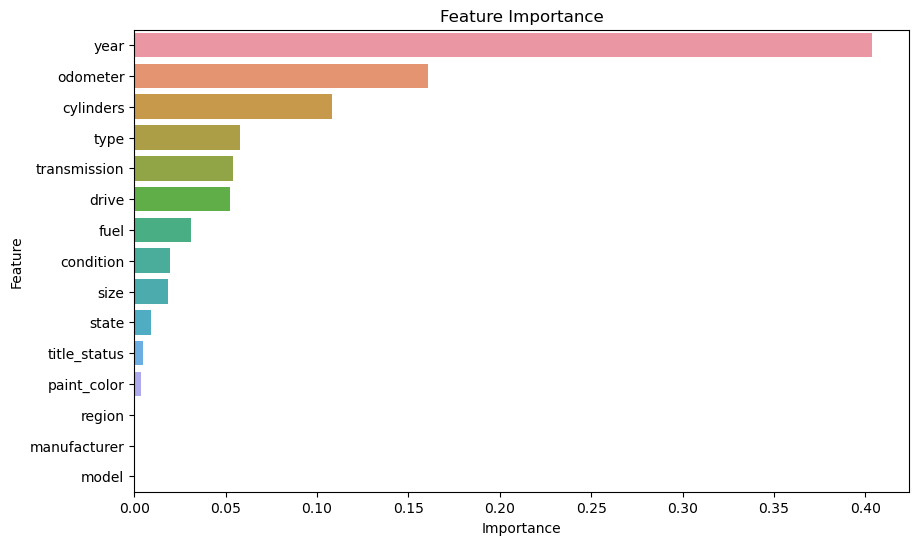

In [174]:
data_dict = {columns[i]: columns[i+1] for i in range(0, len(columns), 2)}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(data_dict.items()), columns=['feature', 'value'])
df_sorted = df.iloc[df['value'].abs().argsort()[::-1]]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='value', y='feature', data=df_sorted)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('images/importance')

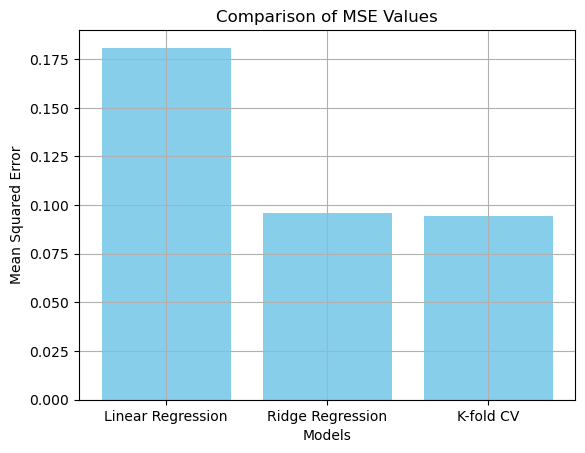

In [177]:
mse_values = [linMse_test, predMse_test, bestMSE_Tt]
labels = ['Linear Regression', 'Ridge Regression', 'K-fold CV']
plt.bar(labels, mse_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of MSE Values')
plt.grid(True)
plt.savefig('images/MSE_comp')

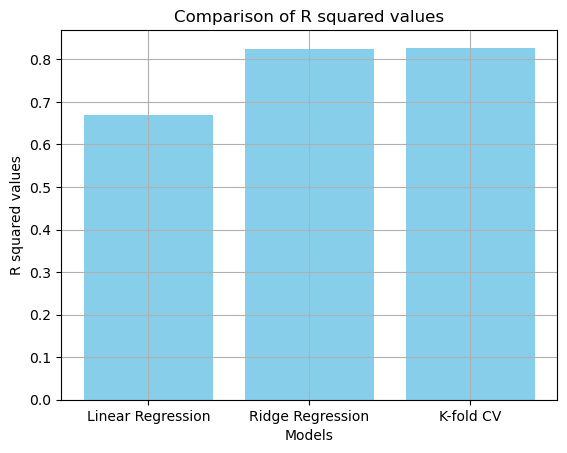

In [178]:
mse_values = [r2_lin, r2_ridge, r2_CV]
labels = ['Linear Regression', 'Ridge Regression', 'K-fold CV']
plt.bar(labels, mse_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R squared values')
plt.title('Comparison of R squared values')
plt.grid(True)
plt.savefig('images/R_comp')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Trained 3 different models. Linear Regression, Ridge regression with polynomial features, and cross validation with ridge estimator.

#### Findings from our model

1. Linear regression model performed the least with the highest MSE and R^2 score. It's top 3 features with the highest coefficients were Year, Cylinder, and transmission.

2. Ridge regression with polynomial features and no alpha value performed better than Linear regression. However, when comparing it's MSE and R^2 score, we can tell that this model is overfitting. It's top features were year, odometer, and type.

3. Cross validation with K-fold 5 and ridge estimator performed the best out of the three. When comparing MSE, we can see that our CV training MSE is slightly higher than our Ridge regression model. However, this is due to the correction of overfitting that was happening with our Ridge model. We can verify this by comparing the R^2 score of our CV model. We see a slight score increase in our test set and the value is extremely close to the training score. This tells that our model is not overfitting.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Objective:
The objective of this analysis is to determine the key drivers affecting the prices of used cars based on feature importance analysis.
#### Key Findings: 
After analyzing our best model's predictions, these are the key findings based on the top features

#### 1. Year:
   Newer model years often translate to higher prices due to research and development that goes into encorporating better          technologies every year and better safety measures.

#### 1. Odometer:
   The odometer reading, representing the mileage of the vehicle, emerges as one of the influential factor affecting the price of used cars. This finding aligns with common expectations, as lower mileage typically correlates with higher vehicle value due to reduced wear and tear.

#### 2. Cylinder:
   Number of cylinder also affected price as higher cylinder count is often associated with higher performance and price points.

### Recommendations:

* Prioritize vehicles with lower year and lower mileage or promote brand new vehicles as premium offerings.

* Consider offering mileage-based incentives or promotions to attract potential buyers.

* Maintain a diverse inventory representing various vehicle engine types to cater to different customer preferences and market segments.

* Monitor market trends and adjust inventory levels of specific vehicle types based on demand fluctuations.
